### Name : Riya Shyam Huddar
### Roll no.: MDS202431

### Pick any 10 stocks (from different 3 sectors) and calculate optimized weights for the 10 stocks for 3 different risk levels; compare the results from Monte Carlo and Convex Optimization


### Portfolio Construction Assumptions

The following assumptions are imposed throughout the analysis:

- **Fully invested portfolio:**

  $$
  \sum_{i=1}^{N} w_i = 1
  $$

- **No short selling:**

  $$
  w_i \ge 0 \quad \forall i
  $$

- **All reported returns and volatilities are annualized.**

- **Arithmetic returns** are used. 
These constraints are applied consistently in both the **Monte Carlo simulation** and **convex optimization** frameworks.


### Stock Universe

We construct a portfolio of **10 U.S. large-cap stocks** across **three sectors** to ensure diversification.

- **Technology:**  
  Apple Inc. (**AAPL**), Microsoft Corporation (**MSFT**), Adobe Inc. (**ADBE**)

- **Financials:**  
  JPMorgan Chase & Co. (**JPM**), BlackRock, Inc. (**BLK**), Visa Inc. (**V**)

- **Healthcare:**  
  Johnson & Johnson (**JNJ**), UnitedHealth Group Incorporated (**UNH**), Abbott Laboratories (**ABT**), Merck & Co., Inc. (**MRK**)

---

### Data Source

- **Source:** Yahoo Finance (`yfinance`)
- **Period:** January 2017 – December 2019  
- **Prices:** Adjusted closing prices (dividends and splits included)

This pre-pandemic period provides stable estimates of return and risk.

---

### Return Calculation

Daily returns are computed using percentage price changes:

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

Missing values are removed to maintain consistency across assets.

---

### Annualized Statistics

Expected returns and covariance are annualized assuming **252 trading days per year**:

$$
\mu = 252 \cdot \mathbb{E}[r_t]
$$

$$
\Sigma = 252 \cdot \text{Cov}(r_t)
$$

These estimates are used as inputs for both **Monte Carlo simulation** and **convex optimization**.


In [85]:
import numpy as np
import pandas as pd
import yfinance as yf


# Define stock universe
tickers = [
    "AAPL",   
    "MSFT",  
    "ADBE",  

    "JPM",    
    "BLK",    
    "V",     

    "JNJ",    
    "UNH",    
    "ABT",    
    "MRK"    
]


# Download price data
prices = yf.download(
    tickers,
    start="2017-01-01",
    end="2019-12-31",
    auto_adjust=True
)["Close"]


# Compute daily returns
daily_returns = prices.pct_change().dropna()


# Annualized statistics
mean_returns = daily_returns.mean() * 252
cov_matrix = daily_returns.cov() * 252


# Display data
mean_returns_table = (
    mean_returns
    .to_frame(name="Expected Annual Return")
    .round(4)
)

cov_matrix_table = cov_matrix.round(4)

display(mean_returns_table)
display(cov_matrix_table)


[*********************100%***********************]  10 of 10 completed


,Expected Annual Return
Ticker,
AAPL,0.3545
ABT,0.3054
ADBE,0.4254
BLK,0.1354
JNJ,0.1177
JPM,0.1992
MRK,0.1845
MSFT,0.3512
UNH,0.2388


Ticker,AAPL,ABT,ADBE,BLK,JNJ,JPM,MRK,MSFT,UNH,V
Ticker,,,,,,,,,,
AAPL,0.0610,0.0216,0.0367,0.0242,0.0109,0.0205,0.0102,0.0335,0.0180,0.0284
ABT,0.0216,0.0365,0.0278,0.0208,0.0141,0.0147,0.0163,0.0243,0.0188,0.0209
ADBE,0.0367,0.0278,0.0767,0.0257,0.0146,0.0172,0.0143,0.0456,0.0216,0.0391
BLK,0.0242,0.0208,0.0257,0.0443,0.0143,0.0280,0.0130,0.0259,0.0169,0.0229
JNJ,0.0109,0.0141,0.0146,0.0143,0.0294,0.0101,0.0135,0.0136,0.0126,0.0108
JPM,0.0205,0.0147,0.0172,0.0280,0.0101,0.0369,0.0091,0.0199,0.0147,0.0172
MRK,0.0102,0.0163,0.0143,0.0130,0.0135,0.0091,0.0327,0.0121,0.0104,0.0114
MSFT,0.0335,0.0243,0.0456,0.0259,0.0136,0.0199,0.0121,0.0471,0.0202,0.0321
UNH,0.0180,0.0188,0.0216,0.0169,0.0126,0.0147,0.0104,0.0202,0.0459,0.0161


### Monte Carlo Portfolio Simulation

Monte Carlo simulation is used to generate a large set of **random, fully invested portfolios** in order to explore the feasible risk–return space.

### Methodology

For each simulated portfolio:

1. **Random weights** are generated for all assets and normalized so that  
   $$
   \sum_{i=1}^{N} w_i = 1
   $$
   

2. **Portfolio expected return** is computed as:
   $$
   R_p = \mathbf{w}^\top \boldsymbol{\mu}
   $$

3. **Portfolio volatility** is computed as:
   $$
   \sigma_p = \sqrt{\mathbf{w}^\top \Sigma \mathbf{w}}
   $$

where $( \boldsymbol{\mu} )$ is the vector of annualized expected returns and $( \Sigma )$ is the annualized covariance matrix.

### Simulation Details

- Number of portfolios: 30,000  
- Weight constraints: long-only, fully invested (w>=0)  
- Random seed fixed for reproducibility  

The output consists of a DataFrame containing portfolio **returns and volatilities**, along with the corresponding asset weight vectors.


In [87]:
def monte_carlo_portfolios(mean_returns, cov_matrix, num_portfolios=10_000, seed=42):
    """
    Generate random portfolios using Monte Carlo simulation.
    """
    np.random.seed(seed)
    
    num_assets = len(mean_returns)
    returns = np.zeros(num_portfolios)
    volatility = np.zeros(num_portfolios)
    weights_array = np.zeros((num_portfolios, num_assets))
    
    for i in range(num_portfolios):
        # Random weights
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        # Portfolio return
        port_return = np.dot(weights, mean_returns)
        
        # Portfolio volatility
        port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        port_volatility = np.sqrt(port_variance)
        
        # Store results
        returns[i] = port_return
        volatility[i] = port_volatility
        weights_array[i, :] = weights
    
    results_df = pd.DataFrame({
        "Return": returns,
        "Volatility": volatility
    })
    
    return results_df, weights_array

In [5]:
# Run Monte Carlo simulation
mc_results_df, mc_weights = monte_carlo_portfolios(
    mean_returns,
    cov_matrix,
    num_portfolios=30_000
)

mc_results_df.head()

,Return,Volatility
0,0.297163,0.165678
1,0.298341,0.162903
2,0.253982,0.150401
3,0.214090,0.142408
4,0.228246,0.148280


### Efficient Frontier

The efficient frontier summarizes portfolios that achieve the **highest expected return for a given level of volatility**.

Portfolios are sorted by increasing volatility, illustrating the risk–return trade-off under the imposed constraints.
Because Monte Carlo simulation produces a discrete set of portfolios, the efficient frontier is approximated by selecting the maximum-return portfolio within small volatility intervals.


In [11]:
# Approximate Monte Carlo Efficient Frontier
num_bins = 50
vol_bins = np.linspace(
    mc_results_df["Volatility"].min(),
    mc_results_df["Volatility"].max(),
    num_bins
)

frontier_vol = []
frontier_ret = []

for i in range(len(vol_bins) - 1):
    mask = (
        (mc_results_df["Volatility"] >= vol_bins[i]) &
        (mc_results_df["Volatility"] < vol_bins[i + 1])
    )
    if mask.any():
        frontier_vol.append(mc_results_df.loc[mask, "Volatility"].mean())
        frontier_ret.append(mc_results_df.loc[mask, "Return"].max())

In [89]:
# Build efficient frontier 
import pandas as pd

frontier_df = pd.DataFrame({
    "Volatility": frontier_vol,
    "Return": frontier_ret
}).sort_values("Volatility").reset_index(drop=True)

frontier_df.head()


,Volatility,Return
0,0.133474,0.226005
1,0.134921,0.234839
2,0.136282,0.245374
3,0.137520,0.247755
4,0.138942,0.251796


### Risk Level Selection

Three representative **risk levels** are identified directly from the Monte Carlo–approximated efficient frontier in order to span the observed risk–return trade-off:

- **Low Risk:** minimum volatility observed along the efficient frontier  
- **Medium Risk:** median volatility along the efficient frontier  
- **High Risk:** maximum volatility observed along the efficient frontier  

These risk levels represent conservative, balanced, and aggressive volatility regimes within the feasible set of Monte Carlo portfolios.

Because efficient frontier points summarize optimal risk–return combinations and do not retain portfolio weights, the final portfolios are obtained by selecting the Monte Carlo portfolios whose volatility is closest to each frontier-based risk level. The resulting portfolios represent the best sampled approximations to the efficient frontier and are used for comparison with convex optimization results.


In [42]:
# Define risk levels
low_idx = frontier_df["Volatility"].idxmin()
mid_idx = (frontier_df["Volatility"] - frontier_df["Volatility"].median()).abs().idxmin()
high_idx = frontier_df["Volatility"].idxmax()

risk_points = {
    "Low Risk": frontier_df.loc[low_idx],
    "Medium Risk": frontier_df.loc[mid_idx],
    "High Risk": frontier_df.loc[high_idx],
}

risk_points


{'Low Risk': Volatility    0.133474
 Return        0.226005
 Name: 0, dtype: float64,
 'Medium Risk': Volatility    0.159533
 Return        0.303854
 Name: 19, dtype: float64,
 'High Risk': Volatility    0.187963
 Return        0.337557
 Name: 39, dtype: float64}

In [44]:
# Compute Sharpe ratio
mc_results_df["Sharpe"] = (
    mc_results_df["Return"] / mc_results_df["Volatility"]
)


# Identify maximum Sharpe portfolio
max_sharpe_idx = mc_results_df["Sharpe"].idxmax()
max_sharpe_vol = mc_results_df.loc[max_sharpe_idx, "Volatility"]
max_sharpe_ret = mc_results_df.loc[max_sharpe_idx, "Return"]


### Monte Carlo Portfolio Selection

For each risk level, the Monte Carlo portfolio whose volatility is **closest to the corresponding efficient-frontier risk level** is selected.

This procedure identifies the best sampled portfolios that approximate the efficient frontier at low, medium, and high-risk regimes, and ensures a consistent comparison between Monte Carlo and convex optimization results at similar levels of risk.


In [46]:
# Extract Monte-Carlo portfolios
mc_selected = {}

for label, row in risk_points.items():
    target_vol = row["Volatility"]

    idx = (mc_results_df["Volatility"] - target_vol).abs().idxmin()

    mc_selected[label] = {
        "Weights": mc_weights[idx],
        "Return": mc_results_df.loc[idx, "Return"],
        "Volatility": mc_results_df.loc[idx, "Volatility"],
        "Sharpe": mc_results_df.loc[idx, "Sharpe"]
    }


### Monte Carlo Optimal Weights

The table below reports the **asset allocation weights** for the Monte Carlo–selected portfolios corresponding to the **low, medium, and high-risk** levels.

Weights represent the fraction of total capital invested in each asset under long-only and fully invested constraints.


In [92]:
# Monte-Carlo weights
mc_weights_frontier_df = pd.DataFrame(
    {k: mc_selected[k]["Weights"] for k in mc_selected},
    index=mean_returns.index
)

display(mc_weights_frontier_df.round(4))


,Low Risk,Medium Risk,High Risk
Ticker,,,
AAPL,0.0325,0.1347,0.2426
ABT,0.1039,0.1445,0.0156
ADBE,0.0050,0.1341,0.3536
BLK,0.1021,0.0744,0.0216
JNJ,0.2268,0.0409,0.0716
JPM,0.1538,0.0771,0.0428
MRK,0.1743,0.0449,0.0327
MSFT,0.0273,0.1168,0.0108
UNH,0.1086,0.1373,0.0231


In [25]:
mc_summary_df = pd.DataFrame({
    label: {
        "Return": mc_selected[label]["Return"],
        "Volatility": mc_selected[label]["Volatility"],
        "Sharpe": mc_selected[label]["Sharpe"],
    }
    for label in mc_selected
}).T

display(mc_summary_df.round(4))


,Return,Volatility,Sharpe
Low Risk,0.2048,0.1334,1.5351
Medium Risk,0.2912,0.1595,1.8251
High Risk,0.3346,0.1880,1.7803


In [27]:
mc_weights_frontier_df.sum()

Low Risk       1.0
Medium Risk    1.0
High Risk      1.0
dtype: float64

### Monte Carlo Efficient Frontier and Sharpe Ratio Visualization

The figure illustrates the results of the Monte Carlo portfolio simulation in **risk–return space**.

- Each point represents a randomly generated, fully invested, long-only portfolio, with color intensity indicating the corresponding **Sharpe ratio**.
- The solid curve denotes the **Monte Carlo approximated efficient frontier**, obtained by identifying the highest-return portfolio within small volatility intervals.
- The star marker highlights the **maximum Sharpe ratio portfolio**, which achieves the best risk-adjusted performance among all sampled portfolios.
- The highlighted points labeled **Low Risk**, **Medium Risk**, and **High Risk** correspond to representative portfolios selected along the efficient frontier and serve as benchmarks for subsequent comparison with convex optimization results.

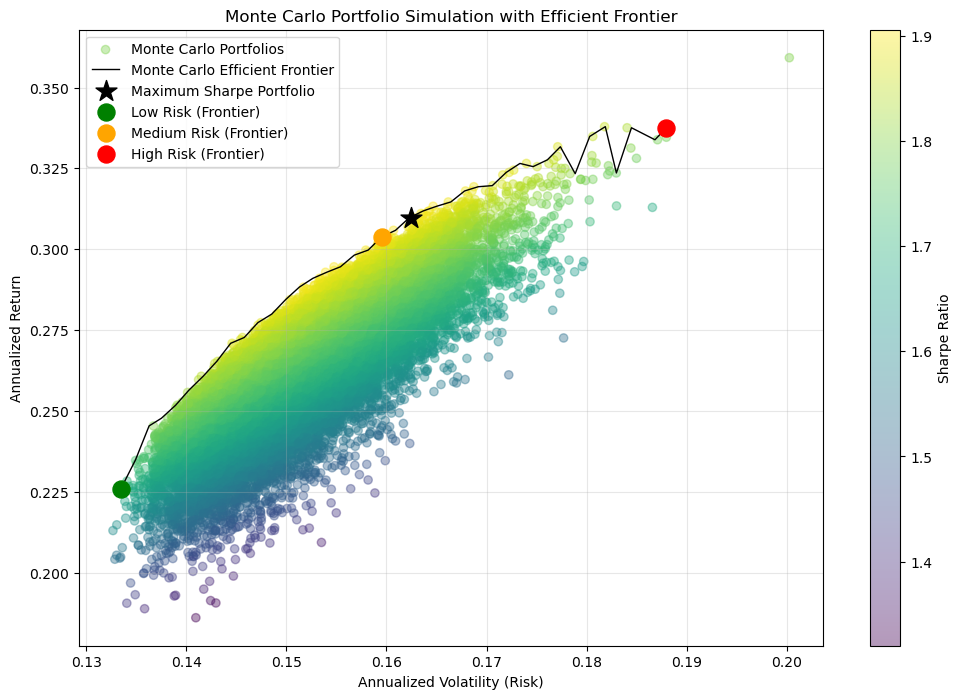

,Return,Volatility,Sharpe
Max Sharpe Portfolio,0.3095,0.1624,1.9058


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Monte Carlo portfolios
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    mc_results_df["Volatility"],
    mc_results_df["Return"],
    c=mc_results_df["Sharpe"],
    cmap="viridis",
    alpha=0.4,
    label="Monte Carlo Portfolios"
)

# Efficient frontier
plt.plot(
    frontier_vol,
    frontier_ret,
    color="black",
    linewidth=1,
    label="Monte Carlo Efficient Frontier"
)

# Maximum Sharpe portfolio
plt.scatter(
    max_sharpe_vol,
    max_sharpe_ret,
    color="black",
    marker="*",
    s=250,
    label="Maximum Sharpe Portfolio",
    zorder=5
)


# Plot Low / Medium / High risk points
plt.scatter(
    risk_points["Low Risk"]["Volatility"],
    risk_points["Low Risk"]["Return"],
    color="green",
    s=150,
    marker="o",
    label="Low Risk (Frontier)",
    zorder=6
)

plt.scatter(
   risk_points["Medium Risk"]["Volatility"],
    risk_points["Medium Risk"]["Return"],
    color="orange",
    s=150,
    marker="o",
    label="Medium Risk (Frontier)",
    zorder=6
)

plt.scatter(
    risk_points["High Risk"]["Volatility"],
    risk_points["High Risk"]["Return"],
    color="red",
    s=150,
    marker="o",
    label="High Risk (Frontier)",
    zorder=6
)

plt.colorbar(scatter, label="Sharpe Ratio")
plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.title("Monte Carlo Portfolio Simulation with Efficient Frontier")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

pd.DataFrame({
    "Return": [max_sharpe_ret],
    "Volatility": [max_sharpe_vol],
    "Sharpe": [mc_results_df.loc[max_sharpe_idx, "Sharpe"]]
}, index=["Max Sharpe Portfolio"]).round(4)


---

### Convex Portfolio Optimization

Convex optimization is used to compute **optimal portfolios analytically** under long-only and fully invested constraints. (w>=0)

The optimizer supports multiple objectives:
- **Minimum Variance:** minimizes portfolio risk
- **Maximum Sharpe Ratio:** maximizes risk-adjusted return using a second-order cone formulation
- **Maximum Return:** allocates fully to highest-return assets
- **Target Volatility:** maximizes return subject to a volatility constraint

All portfolios are evaluated using the same expected returns and covariance matrix, enabling direct comparison with Monte Carlo results.


In [101]:
import cvxpy as cp
import numpy as np
import pandas as pd

def convex_portfolio_optimizer(
    mean_returns,
    cov_matrix,
    objective="min_variance",
    target_vol=None
):
    """
    Convex portfolio optimization function.
    Supports:
    - min_variance
    - max_sharpe
    - max_return
    - target_vol
    """
    n = len(mean_returns)
    w = cp.Variable(n)

    mu = mean_returns.values
    Sigma = cov_matrix.values

    port_return = mu @ w
    port_variance = cp.quad_form(w, Sigma)

    
    # Objective definitions
    if objective == "min_variance":
        constraints = [
            cp.sum(w) == 1,
            w >= 0
        ]
        prob = cp.Problem(
            cp.Minimize(port_variance),
            constraints
        )

    elif objective == "max_sharpe":
        # Sharpe maximization via SOCP
        Sigma_sqrt = np.linalg.cholesky(Sigma)

        constraints = [
            w >= 0,
            cp.norm(Sigma_sqrt @ w, 2) <= 1
        ]

        prob = cp.Problem(
            cp.Maximize(port_return),
            constraints
        )

    elif objective == "max_return":
        constraints = [
            cp.sum(w) == 1,
            w >= 0
        ]
        prob = cp.Problem(
            cp.Maximize(port_return),
            constraints
        )

    elif objective == "target_vol":
        if target_vol is None:
            raise ValueError("target_vol must be provided for target_vol objective")

        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            port_variance <= target_vol ** 2
        ]
        prob = cp.Problem(
            cp.Maximize(port_return),
            constraints
        )

    else:
        raise ValueError("Invalid objective type")

    prob.solve()

   
    # Extract and rescale weights
    weights = w.value

    # For max_sharpe, rescale to fully invested portfolio
    if objective == "max_sharpe":
        weights = weights / np.sum(weights)

    ret = mu @ weights
    vol = np.sqrt(weights.T @ Sigma @ weights)
    sharpe = ret / vol

    return {
        "Weights": weights,
        "Return": ret,
        "Volatility": vol,
        "Sharpe": sharpe
    }


### Efficient Frontier via Convex Optimization

The efficient frontier is also computed using **convex optimization** in order to obtain the *true* optimal risk–return trade-off under the imposed constraints.

For a grid of target volatility levels, the following optimization problem is solved:

$$
\max_{\mathbf{w}} \; \mathbf{w}^\top \boldsymbol{\mu}
\quad \text{subject to} \quad
\mathbf{w}^\top \Sigma \mathbf{w} \le \sigma_{\text{target}}^2,
\quad \sum_{i=1}^{N} w_i = 1,
\quad w_i \ge 0
$$

This formulation yields the maximum expected return achievable at each target level of volatility, producing the **convex efficient frontier**.

Unlike the Monte Carlo frontier, which is based on random sampling and therefore provides only an approximation, the convex optimization approach computes the frontier **exactly** for the specified constraints. The resulting curve is smooth and well-defined, reflecting the global optimum at each risk level.


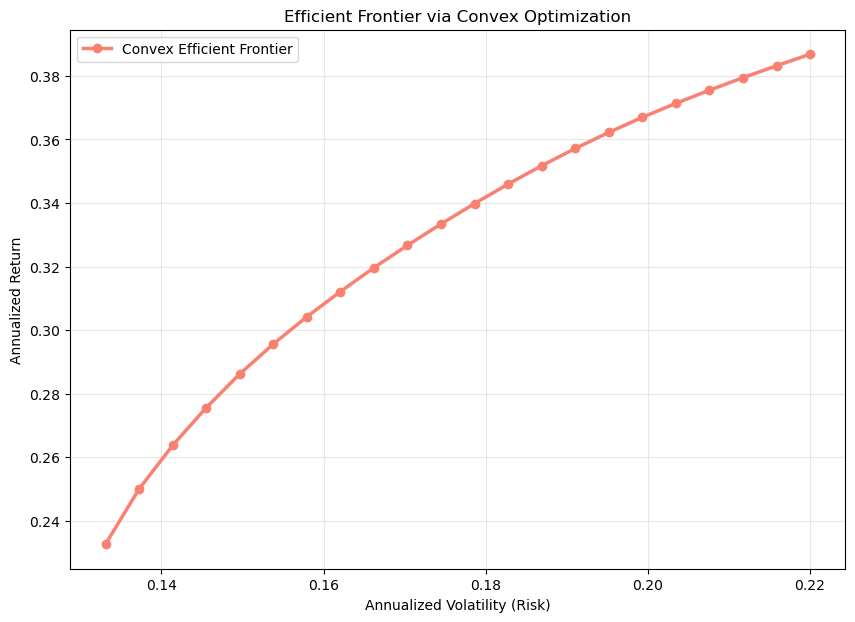

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Build convex efficient frontier using target volatility
vol_grid = np.linspace(
    0.10,   
    0.22,  
    30
)

convex_frontier_vol = []
convex_frontier_ret = []

for vol in vol_grid:
    try:
        res = convex_portfolio_optimizer(
            mean_returns,
            cov_matrix,
            objective="target_vol",
            target_vol=vol
        )
        convex_frontier_vol.append(res["Volatility"])
        convex_frontier_ret.append(res["Return"])
    except:
        pass

# Plot convex efficient frontier
plt.figure(figsize=(10, 7))

plt.plot(
    convex_frontier_vol,
    convex_frontier_ret,
    color="salmon",
    linewidth=2.5,
    marker="o",
    label="Convex Efficient Frontier"
)

plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier via Convex Optimization")
plt.grid(alpha=0.3)
plt.legend()

plt.show()


### Comparison of Monte Carlo and Convex Optimization Frontiers

This figure compares portfolio optimization results obtained via **Monte Carlo simulation** and **convex optimization** under identical long-only and fully invested constraints.

- The cloud of points represents randomly sampled Monte Carlo portfolios, colored by their Sharpe ratios.
- The dashed curve corresponds to the **Monte Carlo approximated efficient frontier**, obtained by selecting the highest-return portfolio within small volatility intervals.
- The solid curve shows the **convex optimization efficient frontier**, which represents the exact optimal risk–return trade-off for the specified constraints.
- The star marker identifies the **maximum Sharpe ratio portfolio** obtained via Monte Carlo simulation.
- The highlighted points denote the **low, medium, and high-risk portfolios** selected for detailed comparison.

The convex efficient frontier is smoother and dominates the Monte Carlo approximation, particularly at higher risk levels, reflecting the exact nature of convex optimization relative to the sampling-based Monte Carlo approach.


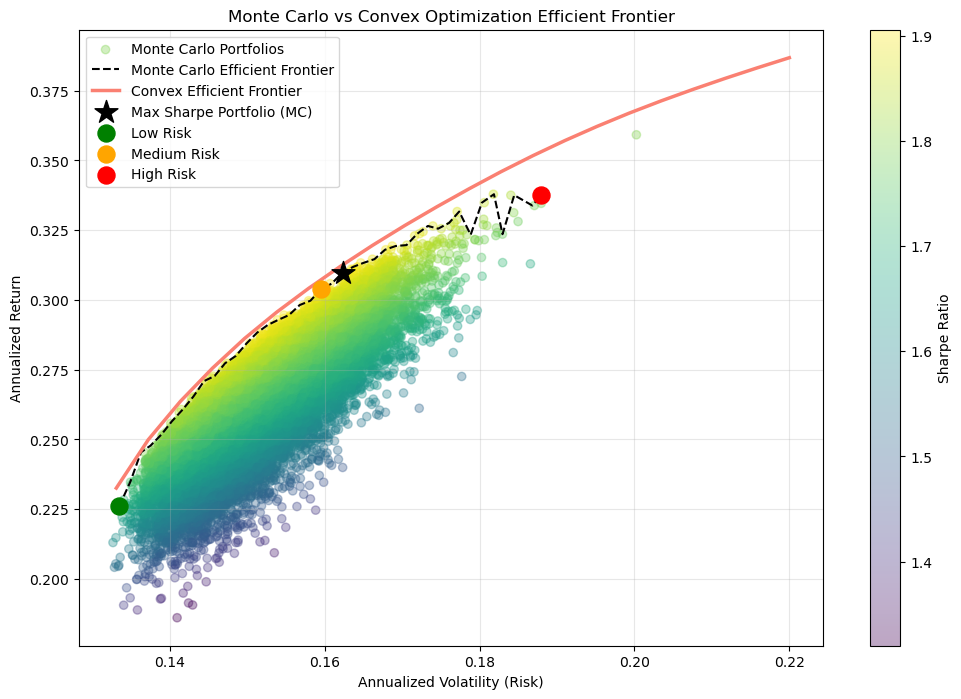

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))


# Monte Carlo portfolios
scatter = plt.scatter(
    mc_results_df["Volatility"],
    mc_results_df["Return"],
    c=mc_results_df["Sharpe"],
    cmap="viridis",
    alpha=0.35,
    label="Monte Carlo Portfolios"
)

# Monte Carlo efficient frontier
plt.plot(
    frontier_vol,
    frontier_ret,
    color="black",
    linewidth=1.5,
    linestyle="--",
    label="Monte Carlo Efficient Frontier"
)

# Convex efficient frontier
plt.plot(
    convex_frontier_vol,
    convex_frontier_ret,
    color="salmon",
    linewidth=2.5,
    label="Convex Efficient Frontier"
)


# Maximum Sharpe portfolio (Monte Carlo)
plt.scatter(
    max_sharpe_vol,
    max_sharpe_ret,
    marker="*",
    color="black",
    s=300,
    label="Max Sharpe Portfolio (MC)",
    zorder=6
)


# Risk points (Monte Carlo frontier)
plt.scatter(
    risk_points["Low Risk"]["Volatility"],
    risk_points["Low Risk"]["Return"],
    color="green",
    s=150,
    label="Low Risk",
    zorder=6
)

plt.scatter(
    risk_points["Medium Risk"]["Volatility"],
    risk_points["Medium Risk"]["Return"],
    color="orange",
    s=150,
    label="Medium Risk",
    zorder=6
)

plt.scatter(
    risk_points["High Risk"]["Volatility"],
    risk_points["High Risk"]["Return"],
    color="red",
    s=150,
    label="High Risk",
    zorder=6
)

plt.colorbar(scatter, label="Sharpe Ratio")
plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Annualized Return")
plt.title("Monte Carlo vs Convex Optimization Efficient Frontier")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


### Convex Optimization with Target Volatility

To enable a direct comparison with Monte Carlo portfolios, convex optimization is performed using **target volatility constraints**.

For each risk level, the optimizer maximizes expected return subject to matching the corresponding efficient frontier volatility.


In [60]:
target_vols = {
    "Low Risk": frontier_df.loc[low_idx, "Volatility"],
    "Medium Risk": frontier_df.loc[mid_idx, "Volatility"],
    "High Risk": frontier_df.loc[high_idx, "Volatility"],
}

convex_target_results = {
    label: convex_portfolio_optimizer(
        mean_returns,
        cov_matrix,
        objective="target_vol",
        target_vol=vol
    )
    for label, vol in target_vols.items()
}


In [62]:
convex_target_weights_df = pd.DataFrame(
    {k: convex_target_results[k]["Weights"] for k in convex_target_results},
    index=mean_returns.index
)

display(convex_target_weights_df.round(4))

convex_target_stats_df = pd.DataFrame(
    {
        "Return": [convex_target_results[k]["Return"] for k in convex_target_results],
        "Volatility": [convex_target_results[k]["Volatility"] for k in convex_target_results],
        "Sharpe": [convex_target_results[k]["Sharpe"] for k in convex_target_results],
    },
    index=convex_target_results.keys()
)

display(convex_target_stats_df.round(4))


,Low Risk,Medium Risk,High Risk
Ticker,,,
AAPL,0.0713,0.1459,0.2034
ABT,0.1235,0.2683,0.3412
ADBE,0.0000,0.1074,0.2661
BLK,0.0000,0.0000,0.0000
JNJ,0.1450,0.0000,0.0000
JPM,0.1418,0.0263,0.0000
MRK,0.2184,0.1208,0.0000
MSFT,0.0000,0.0765,0.1146
UNH,0.1116,0.0853,0.0000


,Return,Volatility,Sharpe
Low Risk,0.2344,0.1335,1.7561
Medium Risk,0.3073,0.1595,1.9262
High Risk,0.3532,0.1880,1.8789


In [126]:
convex_target_weights_df.sum()

Low Risk       1.0
Medium Risk    1.0
High Risk      1.0
dtype: float64

### Convex Optimization: Alternative Risk-Based Portfolios

In addition to the volatility-targeted convex optimization used for direct comparison with Monte Carlo simulation, three canonical convex-optimized portfolios are constructed to illustrate standard risk–return trade-offs in mean–variance theory:

- **Low Risk:** minimum variance portfolio, which minimizes portfolio volatility  
- **Medium Risk:** maximum Sharpe ratio portfolio, which maximizes risk-adjusted return  
- **High Risk:** maximum expected return portfolio, which prioritizes return without explicit risk control  

These portfolios serve as reference benchmarks and provide additional context for interpreting the volatility-targeted optimization results.


In [66]:
convex_low = convex_portfolio_optimizer(mean_returns, cov_matrix, "min_variance")
convex_mid = convex_portfolio_optimizer(mean_returns, cov_matrix, "max_sharpe")
convex_high = convex_portfolio_optimizer(mean_returns, cov_matrix, "max_return")


In [68]:
# Display convex optimization results
convex_obj_weights_df = pd.DataFrame(
    {
        "Low Risk (Min Var)": convex_low["Weights"],
        "Medium Risk (Max Sharpe)": convex_mid["Weights"],
        "High Risk (Max Return)": convex_high["Weights"],
    },
    index=mean_returns.index
)

display(convex_obj_weights_df.round(4))


convex_obj_stats_df = pd.DataFrame(
    {
        "Return": [
            convex_low["Return"],
            convex_mid["Return"],
            convex_high["Return"],
        ],
        "Volatility": [
            convex_low["Volatility"],
            convex_mid["Volatility"],
            convex_high["Volatility"],
        ],
        "Sharpe Ratio": [
            convex_low["Sharpe"],
            convex_mid["Sharpe"],
            convex_high["Sharpe"],
        ],
    },
    index=["Low Risk", "Medium Risk", "High Risk"]
)

display(convex_obj_stats_df.round(4))


,Low Risk (Min Var),Medium Risk (Max Sharpe),High Risk (Max Return)
Ticker,,,
AAPL,0.0177,0.0000,0.0
ABT,0.0229,0.0000,0.0
ADBE,-0.0000,0.0000,1.0
BLK,-0.0000,0.0000,0.0
JNJ,0.2787,0.0134,0.0
JPM,0.1950,0.1106,0.0
MRK,0.2471,0.1358,0.0
MSFT,0.0000,0.2921,0.0
UNH,0.1094,0.0909,0.0


,Return,Volatility,Sharpe Ratio
Low Risk,0.1972,0.1296,1.5217
Medium Risk,0.2851,0.1579,1.8054
High Risk,0.4254,0.2769,1.5364


In [81]:
convex_obj_weights_df.sum()


Low Risk (Min Var)          1.0
Medium Risk (Max Sharpe)    1.0
High Risk (Max Return)      1.0
dtype: float64

### Portfolio Optimization Analysis  
### Monte Carlo Simulation vs Convex Optimization

This report compares portfolio allocations and performance obtained using **Monte Carlo simulation** and **convex optimization** across three risk levels (**Low, Medium, High**) using a universe of 10 stocks across Technology, Financials, and Healthcare sectors.

Risk levels are aligned using **volatility values from the Monte Carlo efficient frontier**, enabling a fair and consistent comparison between methods.

---

### Monte Carlo Portfolios

### Portfolio Weights

Monte Carlo selected portfolios exhibit **broad diversification** across assets at all risk levels, reflecting the random sampling nature of the method.

- **Low Risk:**  
  Heavily weighted toward defensive healthcare and diversified stocks such as  
  **JNJ (22.7%)**, **MRK (17.4%)**, **JPM (15.4%)**, and **ABT (10.4%)**, resulting in low volatility.

- **Medium Risk:**  
  The medium-risk portfolio exhibits a well-balanced allocation across growth, healthcare, and financial stocks. Exposure is relatively evenly distributed among **ABT (14.5%)**, **UNH (13.7%)**, **AAPL (13.5%)**, **ADBE (13.4%)**, and **MSFT (11.7%)**, reflecting a diversified growth-oriented strategy with controlled risk.


- **High Risk:**  
  Strong concentration in high-growth technology stocks:  
  **ADBE (35.4%)**, **AAPL (24.3%)**, and **V (18.6%)**, leading to the highest return and volatility.

---

### Performance Summary (Monte Carlo)

| Risk Level | Return | Volatility | Sharpe |
|-----------|--------|------------|--------|
| Low Risk | 0.2048 | 0.1334 | 1.5351 |
| Medium Risk | 0.2912 | 0.1595 | 1.8251 |
| High Risk | 0.3346 | 0.1880 | 1.7803 |

**Key observations:**
- Return and volatility increase monotonically with risk.
- Sharpe ratio is highest for medium risk.

---

### Monte Carlo Maximum Sharpe Portfolio

The **maximum Sharpe portfolio** identified via Monte Carlo simulation achieves:

| Return | Volatility | Sharpe |
|------|------------|--------|
| 0.3095 | 0.1624 | **1.9058** |


---

### Convex Optimization with Target Volatility

Convex optimization portfolios are constructed by **maximizing expected return subject to the same target volatilities** used for the Monte Carlo portfolios, ensuring a direct and fair comparison across methods.

### Portfolio Weights

The convex-optimized portfolios are **more concentrated** than their Monte Carlo counterparts, reflecting the optimizer’s ability to assign zero weight to inefficient assets:

- **Low Risk:**  
  The low-risk portfolio emphasizes defensive and lower-volatility assets, with notable allocations to **MRK (21.8%)**, **JNJ (14.5%)**, **JPM (14.2%)**, and **V (18.9%)**, while excluding higher-risk growth stocks such as **ADBE** and **MSFT**.

- **Medium Risk:**  
  The medium-risk portfolio is dominated by **ABT (26.8%)**, **V (17.0%)**, and **AAPL (14.6%)**, with additional exposure to **MRK (12.1%)**, **ADBE (10.7%)**, and **MSFT (7.7%)**. This allocation reflects a balanced trade-off between growth and stability at moderate risk levels.

- **High Risk:**  
  The high-risk portfolio exhibits strong concentration in growth-oriented stocks, particularly **ABT (34.1%)**, **ADBE (26.6%)**, **AAPL (20.3%)**, and **MSFT (11.5%)**, with several assets including **BLK**, **JNJ**, **JPM**, **MRK**, and **UNH** receiving zero weight. This highlights the optimizer’s preference for assets with the highest expected returns at elevated risk levels.

### Performance Summary (Convex – Target Volatility)

| Risk Level | Return | Volatility | Sharpe |
|-----------|--------|------------|--------|
| Low Risk | 0.2344 | 0.1335 | **1.7561** |
| Medium Risk | 0.3073 | 0.1595 | **1.9262** |
| High Risk | 0.3532 | 0.1880 | 1.8789 |

**Comparison with Monte Carlo:**
- Convex optimization achieves **higher expected returns and Sharpe ratios at nearly identical volatility levels**.
- The most pronounced improvement occurs at the **medium-risk level**, where the Sharpe ratio increases substantially, indicating more efficient risk–return trade-offs relative to Monte Carlo optimization.
---

### Convex Optimization by Objective (Benchmark Portfolios)

In addition to volatility-targeted convex optimization, three benchmark portfolios are constructed by defining risk levels directly through standard optimization objectives. These portfolios represent canonical solutions in mean–variance portfolio theory and serve as theoretical reference points.

| Portfolio | Return | Volatility | Sharpe |
|---------|--------|------------|--------|
| Minimum Variance | 0.1972 | 0.1296 | 1.5217 |
| Maximum Sharpe | 0.2851 | 0.1579 | **1.8054** |
| Maximum Return | 0.4254 | 0.2769 | 1.5364 |

### Weight Characteristics

- **Minimum Variance Portfolio:**  
  The minimum-variance portfolio is broadly diversified across lower-volatility and defensive assets, with significant allocations to **JNJ (27.9%)**, **MRK (24.7%)**, **JPM (19.5%)**, and **V (12.9%)**, reflecting a strong emphasis on risk minimization.

- **Maximum Sharpe Portfolio:**  
  The maximum Sharpe portfolio is more concentrated, with dominant positions in **V (35.7%)**, **MSFT (29.2%)**, and **MRK (13.6%)**, achieving the highest risk-adjusted return at an intermediate volatility level.

- **Maximum Return Portfolio:**  
  The maximum return portfolio allocates nearly **100% to ADBE**, resulting in extreme concentration and substantially higher volatility. This outcome reflects the optimizer’s sole focus on maximizing expected return without explicit risk control.

